In [5]:
!pip install qiskit #this is just me intalling qiskit into our notebook
!pip install matplotlib plotly #since it says we need a 3d structure to simulate the lattice and any other 3d elements
!pip install numpy
!pip install qiskit-aer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 88.8 MB/s eta 0:00:00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer  # Fixed import
from scipy.optimize import minimize
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer  # Fixed import
from scipy.optimize import minimize
from typing import List, Dict, Tuple

"""
proteins fold in 3D space and here we're working with a simplified lattice model w tetrahedral directions. There are two kinds of alternating sites in the protein chain: 'A' and 'B'.
every turn corresponds to a direction in 3D space either x,y or z
The vectors  [1, 1, 1]) are unit steps in different directions based on the protein structure model.
"""

class SparseDiamondEncoder:
    """Encodes/decodes backbone turns on a diamond (tetrahedral) lattice."""

    # sublattice A basis (even sites)
    _A: Dict[int,np.ndarray] = {
        0: np.array([+1,+1,+1]),    # |00> This is for the first round of qubits represents x,y,z
        1: np.array([+1,-1,-1]),    # |10>
        2: np.array([-1,+1,-1]),    # |01>
        3: np.array([-1,-1,+1]),    # |11>
    }
    # sublattice B basis (odd sites)
    _B: Dict[int,np.ndarray] = {
        0: np.array([+1,+1,-1]),    # |00>
        1: np.array([+1,-1,+1]),    # |10>
        2: np.array([-1,+1,+1]),    # |01>
        3: np.array([-1,-1,-1]),    # |11>
    }

    @staticmethod
    def site_parity(i):
        """Return 'A' if turn index i is even (sublattice A), else 'B'."""
        return 'A' if i % 2 == 0 else 'B'

    @classmethod
    def block_to_vec(cls, block, i):
        """
        Decode one-hot 4-bit string (e.g. '1000') at turn index i into a 3D step vector.
        Raises ValueError if block is not one-hot of length 4.
        """
        if len(block) != 4 or block.count('1') != 1:
            raise ValueError(f"Invalid block {block}, must be one-hot length 4.")
        axis = ['1000','0100','0010','0001'].index(block)
        if cls.site_parity(i) == 'A':
            table = cls._A
        else:
            table = cls._B
        return table[axis]

    @classmethod
    def bitstring_to_turns(cls, bitstr, N):
        """
        Convert full measured bitstring (length=4*(N-3)) into list of N-1 turn vectors:
        - t1 = (+1,+1,+1)
        - t2 = (+1,-1,-1)
        - t3..t_{N-1} from blocks of 4 bits
        """
        expected = 4*(N-3)
        if len(bitstr) != expected:
            raise ValueError(f"Expected bitstring length {expected}, got {len(bitstr)}")
        turns: List[np.ndarray] = []
        # fixed first two turns
        turns.append(cls._A[0])  # t1
        turns.append(cls._A[1])  # t2
        # decode remaining
        for k, start in enumerate(range(0, expected, 4), start=3):
            block = bitstr[start:start+4]
            turns.append(cls.block_to_vec(block, k))
        return turns

    @classmethod
    def turns_to_valid_bitstring(cls, N):
        """Generate a valid one-hot encoded bitstring for testing."""
        n_variable_turns = N - 3
        bitstring = ""
        for i in range(n_variable_turns):
            # Create a one-hot block (randomly pick one position to be '1')
            block = ['0'] * 4
            block[np.random.randint(4)] = '1'
            bitstring += ''.join(block)
        return bitstring


def T(t_i: np.ndarray, t_j: np.ndarray) -> int:
    """
    Indicator: 1 if t_i and t_j lie on same lattice axis or opposite, else 0.
    """
    return int(np.array_equal(t_i, t_j) or np.array_equal(t_i, -t_j))


"""
Hamiltonian defines the cost Hamiltonian terms for a protein fold on a diamond lattice:

1. Growth Constraint (H_gc): penalises consecutive backtracking bonds.
2. Overlap Penalty (H_ov): penalises any pair of beads occupying the same site.
3. Contact Reward (H_ct): rewards non-bonded nearest neighbours.
4. Chirality Constraint (H_ch): enforces correct handedness per sublattice.
5. Interaction Stub (H_in): placeholder for shell-based interaction qubits.

Each method returns a classical float energy for the decoded turn list.
"""

class Hamiltonian:
    def __init__(
        self,
        N: int,  # Number of amino acids
        back_penalty_weight: float = 30.0,
        overlap_weight: float = 50.0,
        contact_reward: float = 10.0,
        chirality_weight: float = 40.0,
        interaction_weights=None,
    ):
        """
        Parameters:
        -----------
        N : Number of amino acids in the protein
        turns : List of N-1 3D step vectors (np.ndarray).
        back_penalty_weight : λ_back for growth constraint.
        overlap_weight : λ_ov for overlap penalty.
        contact_reward : ε for contact reward (>0).
        chirality_weight : λ_chir for chirality penalty.
        """
        self.N = N
        self.total_qubits = 4 * (N - 3)  # Fixed: added total_qubits attribute
        self.λ_back = back_penalty_weight
        self.λ_ov = overlap_weight
        self.ε = contact_reward
        self.λ_chir = chirality_weight
        self.interaction_weights = interaction_weights or {}

    def calculate_energy(self, turns):
        """Calculate total energy for given turns."""
        return (
            self.growth_constraint(turns)
            + self.overlap_penalty(turns)
            + self.contact_reward(turns)  # Fixed method name
            + self.chirality_constraint(turns)
            + self.interaction_constraint(turns)
        )

    def total_energy(self, bitstring):
        """
        Calculate energy from bitstring by first decoding to turns.
        This is what CVARVQE calls.
        """
        try:
            turns = SparseDiamondEncoder.bitstring_to_turns(bitstring, self.N)
            return self.calculate_energy(turns)
        except ValueError:
            # If bitstring is invalid, return high penalty
            return 1000.0

    def growth_constraint(self, turns):
        """
        H_gc = λ_back * Σ_{i=3..N-1} T(t_i, t_{i+1}).
        """
        H_gc = 0.0
        for i in range(2, len(turns) - 1):
            H_gc += self.λ_back * T(turns[i], turns[i + 1])
        return H_gc

    def overlap_penalty(self, turns):
        """
        H_ov = λ_ov * Σ overlap penalty for beads at same position
        """
        pos = [(0, 0, 0)]
        for t in turns:
            prev = np.array(pos[-1])
            pos.append(tuple(prev + t))

        H_ov = 0.0
        # Check for overlaps
        for i in range(len(pos)):
            for j in range(i + 1, len(pos)):
                if pos[i] == pos[j]:
                    H_ov += self.λ_ov
        return H_ov

    def contact_reward(self, turns):  # Fixed method name
        """
        H_ct = -ε * Σ contact rewards for non-bonded nearest neighbors
        """
        pos = [(0, 0, 0)]
        for t in turns:
            prev = np.array(pos[-1])
            pos.append(tuple(prev + t))

        H_ct = 0.0
        # threshold for nearest neighbor on diamond lattice
        nn_dist = np.sqrt(3)
        tol = 1e-6
        for i in range(len(pos)):
            # |i-j|>2 for non-bonded neighbors
            for j in range(i + 3, len(pos)):
                d = np.linalg.norm(np.array(pos[i]) - np.array(pos[j]))
                if abs(d - nn_dist) < tol:
                    H_ct += -self.ε
        return H_ct

    def chirality_constraint(self, turns):
        """
        H_ch = λ_chir * Σ_{i=2..N-2} indicator of wrong handedness;
        uses scalar triple product and sublattice parity.
        """
        H_ch = 0.0
        for i in range(2, len(turns) - 1):
            if i >= len(turns) - 1:
                break
            v_prev = turns[i - 1]
            v_curr = turns[i]
            v_side = turns[i + 1] if i + 1 < len(turns) else turns[i]
            triple = np.dot(np.cross(v_prev, v_curr), v_side)
            parity = (1 - (-1) ** i) // 2
            # expect triple>0 on A (parity=0), <0 on B (parity=1)
            if not ((parity == 0 and triple > 0) or (parity == 1 and triple < 0)):
                H_ch += self.λ_chir
        return H_ch

    def interaction_constraint(self, turns):
        """Interaction constraint based on distance shells."""
        H_in = 0.0
        # build bead positions
        pos = [(0, 0, 0)]
        for t in turns:
            prev = np.array(pos[-1])
            pos.append(tuple(prev + t))
        tol = 1e-6
        for shell, weight in self.interaction_weights.items():
            for i in range(len(pos)):
                for j in range(i + 3, len(pos)):
                    d = np.linalg.norm(np.array(pos[i]) - np.array(pos[j]))
                    if abs(d - shell) < tol:
                        H_in += weight
        return H_in


def create_configuration_circuit(N):
    """
    Allocate 4*(N-3) config qubits in a register, apply Hadamard to each,
    and attach classical bits for measurement.
    Returns (qc, cfg, meas).
    """
    n_cfg = 4*(N-3)
    cfg = QuantumRegister(n_cfg, 'cfg')
    meas = ClassicalRegister(n_cfg, 'meas')
    qc = QuantumCircuit(cfg, meas)
    qc.h(cfg)
    return qc, cfg, meas


def decode_measurement(counts, N):
    """
    From measurement counts, pick the most frequent bitstring and decode into turn vectors.
    """
    bitstr = max(counts, key=counts.get)
    return SparseDiamondEncoder.bitstring_to_turns(bitstr, N)

def turns_to_coords(turns):
    """
    Convert a list of turn vectors (each is a 3D step on the diamond lattice)
    into absolute coordinates for plotting.

    Parameters
    ----------
    turns : list of np.ndarray or tuples
        Each element is a 3D step like (1,-1,1) etc.

    Returns
    -------
    np.ndarray of shape (len(turns)+1, 3)
        Absolute positions of each amino-acid bead along the chain.
    """
    pts = [np.array([0, 0, 0], dtype=int)]      # Start at origin; first bead at (0,0,0)
    for t in turns:                              # For each step vector...
        pts.append(pts[-1] + np.array(t))        # Add it to the last coord to get next position
    return np.vstack(pts)                        # Stack into a single 2D array for plotting


def plot_fold(coords, title="Fold"):
    """
    Plot the 3D backbone using Matplotlib.

    Parameters
    ----------
    coords : np.ndarray
        Output of turns_to_coords (x,y,z positions).
    title  : str
        Title shown on the plot.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')   # Create a 3D subplot
    ax.plot(coords[:, 0], coords[:, 1], coords[:, 2], marker='o')  # Connect beads with lines + markers
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')     # Axis labels
    ax.set_title(title)                                           # Title
    plt.show()                                                    # Render


BLOCK = 4  # One-hot block size: each turn is encoded with 4 qubits

def clean_bits(bitstring, n_qubits):
    """
    Qiskit often gives bitstrings with spaces and reversed order.
    We remove spaces and keep the last n_qubits bits (correct ordering).

    Example: '0110 1001' -> '01101001' -> (take last n bits)
    """
    return bitstring.replace(" ", "")[-n_qubits:]


def is_valid_onehot(bitstring):
    """
    Check if every 4-bit block has exactly one '1' (enforces one-hot encoding).
    Example: '01000001' (two blocks: '0100' and '0001') -> valid.
    """
    for i in range(0, len(bitstring), BLOCK):
        if bitstring[i:i+BLOCK].count('1') != 1:
            return False
    return True


def repair_onehot(bitstring):
    """
    Heuristic repair: ensures each 4-bit block becomes one-hot.
    - If exactly one '1' → keep it.
    - If zero or many '1's → choose the first '1'; if none, force index 0 = '1'.

    NOTE: The paper enforces constraints via Hamiltonian & extra qubits.
          This is a pragmatic post-processing fix to salvage samples.
    """
    repaired_blocks = []
    for i in range(0, len(bitstring), BLOCK):
        block = bitstring[i:i+BLOCK]
        if block.count('1') == 1:
            repaired_blocks.append(block)       # Already good
        else:
            idx = block.find('1')               # Find first '1'
            if idx == -1:                       # If no '1' at all...
                idx = 0                         # Force first bit to 1
            new_block = ['0'] * BLOCK
            new_block[idx] = '1'
            repaired_blocks.append(''.join(new_block))
    return ''.join(repaired_blocks)


class CVARVQE:
    """
    1. ansatz: H → (RY + entangle)^m → final RY
    2. Configurable depth (m_layers) & entanglement pattern (ring/all)
    3. Cleans and repairs invalid one-hot bitstrings
    4. Computes CVaR only over VALID energies (ignores very high energies like 1000)
    5. Optimizer enforces COBYLA iteration rule and can return per-call traces
    """

    def __init__(self,
                 hamiltonian,             #object
                 alpha=0.2,               #float, CVaR quantile (0<alpha<=1), ex. 0.2 averages best 20%
                 backend=None,            #Qiskit backend (defaults to Aer qasm simulator)
                 invalid_energy=1000.0,   #float, energy used to tag bad configurations
                 m_layers=2,              #int, number of (RY + entangle) blocks
                 entangle="ring",         #str, "ring" (CNOT loop) or "all" (all-to-all CNOTs)
                 repair=True):            #bool, if True, try to repair bad one-hot blocks
        self.ham = hamiltonian
        self.alpha = alpha
        self.n_qubits = self.ham.total_qubits
        self.backend = backend or Aer.get_backend("qasm_simulator")
        self.invalid_energy = invalid_energy
        self.m_layers = m_layers
        self.entangle = entangle
        self.repair = repair


    # 1) Build the ansatz circuit
    def create_ansatz(self, params, m=None, entangle=None):
        """
          H on all qubits
          Repeat m times:  RY layer  + entangle block
          Final RY layer

        Total parameters = (m + 1) * n_qubits

        check length strictly to mismatches early.
        """
        # Use object's defaults if None passed
        if m is None:
            m = self.m_layers
        if entangle is None:
            entangle = self.entangle

        n = self.n_qubits
        expected = (m + 1) * n
        if len(params) != expected:
            raise ValueError(f"params len {len(params)} != expected {expected} ((m+1)*n_qubits)")

        qc = QuantumCircuit(n)
        k = 0  #index

        # Hadamards (|+> superposition)
        for q in range(n):
            qc.h(q)

        # × (RY + entangle)
        for _ in range(m):
            # Single-qubit Y rotations
            for q in range(n):
                qc.ry(params[k], q); k += 1

            # Entangling block
            if entangle == "all":
                # Connect every pair
                for ctrl in range(n):
                    for tgt in range(ctrl + 1, n):
                        qc.cx(ctrl, tgt)
            else:
                # "ring": chain plus wrap to first qubit
                for q in range(n - 1):
                    qc.cx(q, q + 1)
                qc.cx(n - 1, 0)

        # Final RY layer
        for q in range(n):
            qc.ry(params[k], q); k += 1

        return qc

    # 2) Sample the circuit and get counts
    def sample_counts(self, params, shots=1024, m=None):
        """
        Construct the circuit with given params, measure it, and return
        a dictionary: {bitstring: count}.
        """
        qc = self.create_ansatz(params, m=m)
        cr = ClassicalRegister(self.n_qubits, "m") # classical bits to store measurements
        qc.add_register(cr)
        qc.measure(range(self.n_qubits), range(self.n_qubits))  # measure all qubits

        result = self.backend.run(qc, shots=shots).result()      # simulate
        return result.get_counts()                               # dict of bitstrings → counts


    # 3) Convert counts → list of energies
    def counts_to_energies(self, counts):
        """
        For each measured bitstring, compute its energy and extend the
        list by its count (so frequent bitstrings weigh more).
        Bad blocks: either repair them (if self.repair) or assign invalid_energy.
        """
        energies = []
        for bitstring, count in counts.items():
            cleaned = clean_bits(bitstring, self.n_qubits)

            # If it's not one-hot valid
            if not is_valid_onehot(cleaned):
                if self.repair:
                    cleaned = repair_onehot(cleaned)          # attempt to fix
                else:
                    energies.extend([self.invalid_energy] * count)
                    continue

            # Score this configuration
            e = self.ham.total_energy(cleaned)
            energies.extend([e] * count)

        return np.array(energies)

    # 4) CVaR objective
    def evaluate_energy(self, params, shots=1024, m=None):
        """
        Compute CVaR(α) on valid energies only:

        1. Sample circuit → counts
        2. Convert counts to energies list
        3. Filter invalid ones (>= invalid_energy)
        4. Sort remaining energies
        5. Average the best α-fraction
        """
        counts = self.sample_counts(params, shots=shots, m=m)
        energies = self.counts_to_energies(counts)

        # Keep only valid energies
        valid = energies[energies < self.invalid_energy]
        if valid.size == 0:
            return float(self.invalid_energy)

        valid.sort()
        k = max(1, int(self.alpha * len(valid)))  # number of samples in the CVaR tail
        return float(valid[:k].mean())

    # 5) Optimize parameters (COBYLA)
    def optimize(self,
                 initial_params=None,
                 maxiter=50,
                 shots=1024,
                 m=None,
                 return_trace=False):
        """
        Minimize CVaR energy using COBYLA.

        - If initial_params is None, randomize with correct size.
        - Ensure maxiter >= num_params + 2 (COBYLA requirement).
        - Log each objective call in 'trace' if requested.

        Returns
        -------
        best_params : np.ndarray
        best_energy : float
        trace       : list[float]   (only if return_trace=True)
        """
        if m is None:
            m = self.m_layers

        # Create random starting point if not provided
        if initial_params is None:
            expected = (m + 1) * self.n_qubits
            initial_params = np.random.uniform(0, 2*np.pi, expected)

        n_vars = initial_params.size
        maxiter = max(maxiter, n_vars + 2)  # COBYLA: needs at least n+2

        trace = []  # to store energy progression

        def objective(x):
            val = self.evaluate_energy(x, shots=shots, m=m)
            trace.append(val)
            return val

        res = minimize(objective,
                       initial_params,
                       method="COBYLA",
                       options={"maxiter": maxiter, "disp": False})

        if return_trace:
            return res.x, float(res.fun), trace
        else:
            return res.x, float(res.fun)

    # 6) Grab the single lowest-energy valid bitstring from a fresh sample
    def best_bitstring(self, params, shots=4096, m=None):
        """
        This function samples again and returns the lowest-energy VALID bitstring.

        Returns
        -------
        (bitstring, energy)  or  (None, inf) if none valid (and repair=False)
        """
        counts = self.sample_counts(params, shots=shots, m=m)
        best_e, best_b = float("inf"), None

        for bitstring in counts.keys():
            cleaned = clean_bits(bitstring, self.n_qubits)
            if not is_valid_onehot(cleaned):
                if self.repair:
                    cleaned = repair_onehot(cleaned)
                else:
                    continue
            e = self.ham.total_energy(cleaned)
            if e < best_e:
                best_e, best_b = e, cleaned

        return best_b, best_e


In [23]:



# Test everything
if __name__ == "__main__":

    print("this is just a test psssss")

    # Test 1: SparseDiamondEncoder with valid bitstring
    print("\n1. Testing SparseDiamondEncoder...")
    N = 6
    valid_bitstring = SparseDiamondEncoder.turns_to_valid_bitstring(N)
    print(f"Valid test bitstring: {valid_bitstring}")
    try:
        turns = SparseDiamondEncoder.bitstring_to_turns(valid_bitstring, N)
        print(f"Decoded turns: {[tuple(t) for t in turns]}")
        print("✓ SparseDiamondEncoder working!")
    except Exception as e:
        print(f"✗ SparseDiamondEncoder failed: {e}")

    # Test 2: Hamiltonian
    print("\n2. Testing Hamiltonian...")
    try:
        ham = Hamiltonian(N)
        energy = ham.total_energy(valid_bitstring)
        print(f"Total energy for test configuration: {energy}")
        print("✓ Hamiltonian working!")
    except Exception as e:
        print(f"✗ Hamiltonian failed: {e}")

    # Test 3: CVARVQE
    print("\n3. Testing CVARVQE...")
    try:
        ham = Hamiltonian(N)
        # m_layers=1 so we need 2*total_qubits parameters, ring entanglement, no repair for this test
        vqe = CVARVQE(ham, alpha=0.1, m_layers=1, entangle="ring", repair=False)

        # Test circuit creation: (m+1)*n_qubits = 2 * ham.total_qubits
        test_params = np.random.uniform(0, 2*np.pi, 2 * ham.total_qubits)
        circuit = vqe.create_ansatz(test_params, m=1)
        print(f"Created VQE circuit with {circuit.num_qubits} qubits")

        # Test energy evaluation: shots=100, m=1
        energy = vqe.evaluate_energy(test_params, shots=100, m=1)
        print(f"Test energy evaluation: {energy}")
        print("✓ CVARVQE working!")
    except Exception as e:
        print(f"✗ CVARVQE failed: {e}")

    # Test 4: Quick optimization (with automatic repair & safe decoding)
    print("\n4. Running quick optimization...")
    try:
        # 4a) Build a smaller problem (N=5 → 4*(5-3)=8 qubits)
        ham_small = Hamiltonian(5)
        vqe_small = CVARVQE(
            ham_small,
            alpha=0.2,
            m_layers=1,
            entangle="ring",
            repair=True      # enable one-hot repair
        )

        # 4b) Run a quick COBYLA optimization
        print("Starting optimization (this may take a moment)...")
        best_params, best_energy = vqe_small.optimize(
            maxiter=10,
            shots=200,
            m=1,
            return_trace=False
        )

        print(f"Best energy found: {best_energy:.2f}")
        print(f"Best parameters (first 3): {best_params[:3]}...")

        # 4c) Sample and automatically pick the best valid bitstring
        best_bitstring, best_e = vqe_small.best_bitstring(
            best_params,
            shots=1000,
            m=1
        )
        print(f"Best configuration bitstring: {best_bitstring}")
        print(f"Energy of that bitstring: {best_e:.2f}")

        # 4d) Decode the bitstring into turns
        best_turns = SparseDiamondEncoder.bitstring_to_turns(best_bitstring, 5)
        print(f"Best folding turns: {[tuple(t) for t in best_turns]}")

        print("✓ Optimization complete!")
    except Exception as e:
        print(f"✗ Optimization failed: {e}")

        # look into beta sheets and alpha sheets maybe to understand how to categorize folds
        # four different levels of protein structure: look into tertiary structure.

this is just a test psssss

1. Testing SparseDiamondEncoder...
Valid test bitstring: 000101001000
Decoded turns: [(np.int64(1), np.int64(1), np.int64(1)), (np.int64(1), np.int64(-1), np.int64(-1)), (np.int64(-1), np.int64(-1), np.int64(-1)), (np.int64(1), np.int64(-1), np.int64(-1)), (np.int64(1), np.int64(1), np.int64(-1))]
✓ SparseDiamondEncoder working!

2. Testing Hamiltonian...
Total energy for test configuration: 30.0
✓ Hamiltonian working!

3. Testing CVARVQE...
Created VQE circuit with 12 qubits
Test energy evaluation: 130.0
✓ CVARVQE working!

4. Running quick optimization...
Starting optimization (this may take a moment)...
Best energy found: -0.50
Best parameters (first 3): [3.29880969 2.0014363  5.40292818]...
Best configuration bitstring: 00010010
Energy of that bitstring: -10.00
Best folding turns: [(np.int64(1), np.int64(1), np.int64(1)), (np.int64(1), np.int64(-1), np.int64(-1)), (np.int64(-1), np.int64(-1), np.int64(-1)), (np.int64(-1), np.int64(1), np.int64(-1))]
✓ Op


=== alpha = 1.00 ===

=== alpha = 0.80 ===

=== alpha = 0.60 ===

=== alpha = 0.40 ===

=== alpha = 0.20 ===

Optimization finished.
Alpha/Energy history: [(np.float64(1.0), 15.48828125), (np.float64(0.8), -0.463980463980464), (np.float64(0.6), -3.3957654723127035), (np.float64(0.3999999999999999), -9.267399267399268), (np.float64(0.2), -10.28117359413203)]


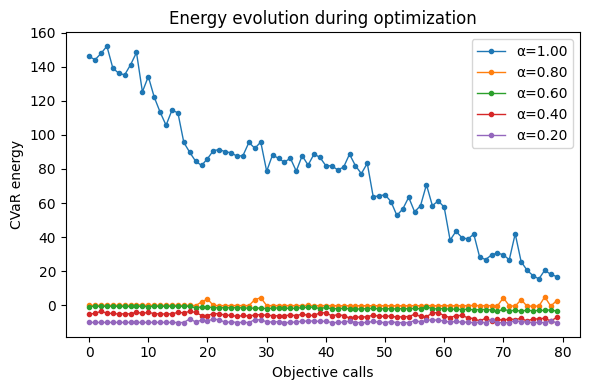

Best bitstring: 00010010001010000010
Best energy: -15.0


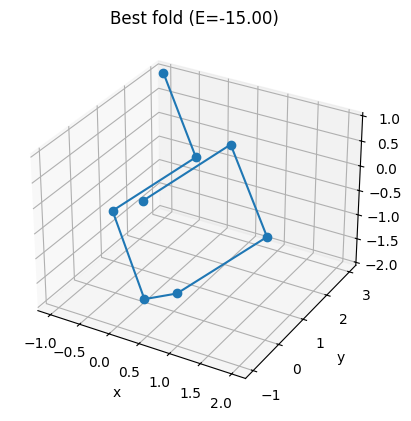

In [22]:
# Config
N = 8
alpha_final = 0.2
alpha_steps = 5
M_LAYERS = 2
shots = 2048
maxiter_per_stage = 80     # COBYLA will auto-bump if too small


ham = Hamiltonian(
    N=N,
    back_penalty_weight=100.0,
    overlap_weight=100.0,
    contact_reward=5.0,
    chirality_weight=0.0
)

vqe = CVARVQE(ham,
              alpha=alpha_final,
              m_layers=M_LAYERS,
              entangle="ring",
              repair=True)              # repair invalid one-hot blocks

alphas = np.linspace(1.0, alpha_final, alpha_steps)  # e.g. 1.0 → 0.2
params = None
history = []          # (alpha, best_energy) at each stage
stage_traces = []     # list of per-call energies for plotting

for a in alphas:
    vqe.alpha = a                              # set current CVaR tail
    print(f"\n=== alpha = {a:.2f} ===")
    params, best_E, trace = vqe.optimize(initial_params=params,
                                         maxiter=maxiter_per_stage,
                                         shots=shots,
                                         return_trace=True)  # get per-call trace
    history.append((a, best_E))
    stage_traces.append(trace)

print("\nOptimization finished.")
print("Alpha/Energy history:", history)

plt.figure(figsize=(6, 4))
for a, tr in zip(alphas, stage_traces):
    plt.plot(tr, marker='.', linewidth=1, label=f'α={a:.2f}')
plt.xlabel("Objective calls")
plt.ylabel("CVaR energy")
plt.title("Energy evolution during optimization")
plt.legend()
plt.tight_layout()
plt.show()


best_bit, best_E = vqe.best_bitstring(params, shots=4096)
print(f"Best bitstring: {best_bit}\nBest energy: {best_E}")

if best_bit is None:
    raise RuntimeError("No valid bitstring sampled. Increase shots/depth or keep repair=True.")

best_turns = SparseDiamondEncoder.bitstring_to_turns(best_bit, ham.N)
coords = turns_to_coords(best_turns)
plot_fold(coords, f"Best fold (E={best_E:.2f})")